<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 2

</h4>

# Personal Data

In [1]:
# Set your student number
student_number =  99102189
Name = 'Mohammad'
Last_Name = 'Mohammad Beigi'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch.

## Question 1) Convolutional Neural Networks ``(50 pt.)``

In this question, you'll be coding up a convolutional neural network from scratch to classify images using PyTorch.  

### Instructions
- Install PyTorch following the instructions [here](https://pytorch.org/).
- Install the [`torchinfo` package](https://github.com/TylerYep/torchinfo) to visualize the network architecture and the number of parameters. The maximum number of parameters you are allowed to use for your network is **100,000**.
- You are required to complete the functions defined in the code blocks following each question. Fill out sections of the code marked `"YOUR CODE HERE"`.
- You're free to add any number of methods within each class.
- You may also add any number of additional code blocks that you deem necessary.

### Data Preparation
In this assignment, we will use the Fashion-MNIST dataset. Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.  

#### Data

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.  

#### Labels

Each training and test example is assigned to one of the following labels:

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Fashion-MNIST is included in the `torchvision` library.

In [2]:
# Import required packages
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize
import matplotlib.pyplot as plt

In [3]:
# Transform to normalize the data and convert to a tensor
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

# Download the data
dataset = FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)

### Data Exploration
Let's take a look at the classes in our dataset.

In [4]:
print(dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Now, visualize an instance from each class.

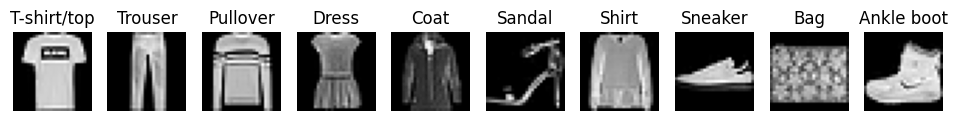

In [5]:
import matplotlib.pyplot as plt

def visualize_classes(dataset):
    class_names = dataset.classes
    fig, axes = plt.subplots(1, len(class_names), figsize=(12, 3))
    for i, ax in enumerate(axes):
        idx = (dataset.targets == i).nonzero()[0][0]  # Find first instance of each class
        img, label = dataset[idx]
        ax.imshow(img.squeeze(), cmap='gray')  # Assuming grayscale image
        ax.set_title(class_names[label])
        ax.axis('off')
    plt.show()

visualize_classes(dataset)  # Call the function

### Creating Training and Validation Datasets

The `split_indices` function takes in the size of the entire dataset, `n`, the fraction of data to be used as validation set, `val_frac`, and the random seed and returns the indices of the data points to be added to the validation dataset.

In [6]:
import numpy as np

def split_indices(n, val_frac, seed):
    # Determine the size of the validation set
    n_val = int(val_frac * n)
    np.random.seed(seed)
    # Create random permutation between 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [7]:
# Parameters to define
val_frac = 0.2  # Using 20% of the data for validation
rand_seed = 42  # Seed for reproducibility

# Assuming 'dataset' is already defined and loaded
train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)
print("number of samples in training set: {}".format(len(train_indices)))
print("number of samples in validation set: {}".format(len(val_indices)))

number of samples in training set: 48000
number of samples in validation set: 12000


Next, we make use of the built-in dataloaders in PyTorch to create iterables of our our training and validation sets. This helps in avoiding fitting the whole dataset into memory and only loads a batch of the data that we can decide.

In [8]:
# Import required packages
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [9]:
# Set the batch size
batch_size = 64  # Common batch sizes are 32, 64, 128, etc.

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                     batch_size=batch_size,  # Ensure you set the batch size here
                     sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                   batch_size=batch_size,  # Ensure you set the batch size here
                   sampler=val_sampler)

Plot images in a sample batch of data.

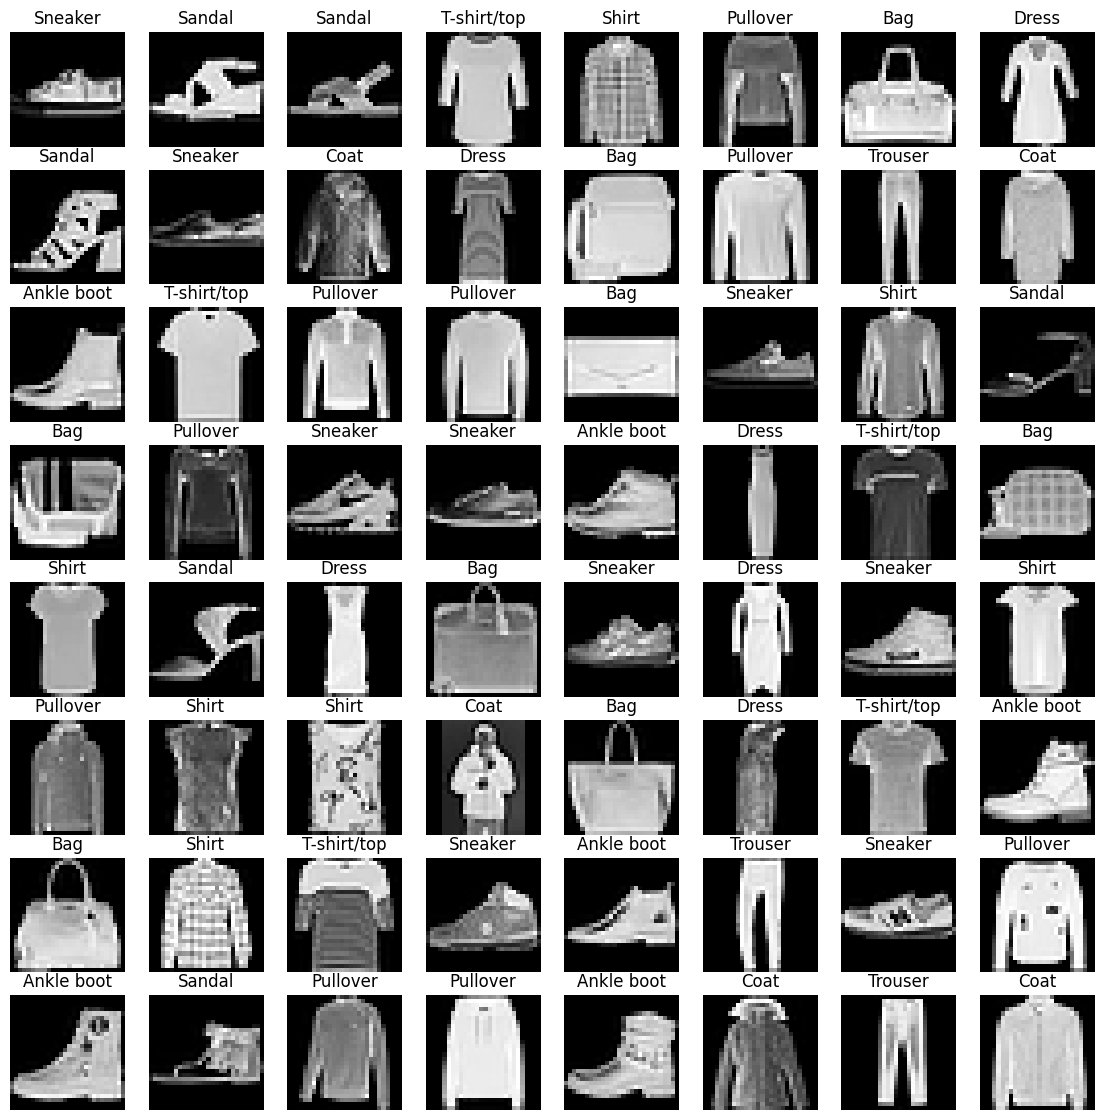

In [10]:
import matplotlib.pyplot as plt

# Function to plot images in a batch
def show_images(images, labels, class_names):
    fig, axes = plt.subplots(8, 8, figsize=(14, 14))  # Create an 8x8 grid of plots
    axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier indexing
    for idx, (img, label) in enumerate(zip(images, labels)):
        ax = axes[idx]
        if img.shape[0] == 3:  # Check if the image has 3 channels
            img = img.permute(1, 2, 0)  # Change CxHxW to HxWxC for RGB images
        else:
            img = img.squeeze()  # Remove channel dimension for grayscale images
        ax.imshow(img, cmap='gray')  # Use gray color map for grayscale images
        ax.set_title(class_names[label])
        ax.axis('off')
    plt.show()

# Retrieve a single batch from the training DataLoader
for images, labels in train_dl:
    show_images(images[:64], labels[:64], dataset.classes)  # Adjust the slice size as needed
    break  # Only show the first batch


### Building the Model
Create your model by defining the network architecture in the `ImageClassifierNet` class.<br>
**NOTE:** The number of parameters in your network must be $\leq$ 100,000.

In [11]:
!pip install torchinfo
# Import required packages
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [12]:
class ImageClassifierNet(nn.Module):
    def __init__(self, n_channels=3):
        super(ImageClassifierNet, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 3 * 3, 128)  # Corrected input size
        self.fc2 = nn.Linear(128, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2)  # (batch_size, 16, 14, 14)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2)  # (batch_size, 32, 7, 7)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2)  # (batch_size, 64, 3, 3)
        X = X.view(X.size(0), -1)  # Flatten the tensor
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return X

In [13]:
model = ImageClassifierNet(n_channels=1)

The following code block prints your network architecture. It also shows the total number of parameters in your network (see `Total params`).  

**NOTE: The total number of parameters in your model should be <= 100,000.**

In [14]:
summary(model, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       [64, 10]                  --
├─Conv2d: 1-1                            [64, 16, 28, 28]          160
├─Conv2d: 1-2                            [64, 32, 14, 14]          4,640
├─Conv2d: 1-3                            [64, 64, 7, 7]            18,496
├─Linear: 1-4                            [64, 128]                 73,856
├─Linear: 1-5                            [64, 10]                  1,290
Total params: 98,442
Trainable params: 98,442
Non-trainable params: 0
Total mult-adds (M): 129.05
Input size (MB): 0.20
Forward/backward pass size (MB): 11.31
Params size (MB): 0.39
Estimated Total Size (MB): 11.90

### Train the model
Complete the `train_model` function to train your model on a dataset. Tune your network architecture and hyperparameters on the validation set.

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.

    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer function
        lr: learning rate

    Returns:
        model: the trained model
        train_loss_history: training loss history
        val_loss_history: validation loss history
        train_acc_history: training accuracy history
        val_acc_history: validation accuracy history
    """
    optimizer = opt_fn(model.parameters(), lr=lr)
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_dl:
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_dl)
        train_acc = correct / total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_dl:
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_dl)
        val_acc = correct / total
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [16]:
# Example usage
num_epochs = 10
lr = 0.001
loss_fn = nn.CrossEntropyLoss()
opt_fn = optim.Adam

In [17]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)

Epoch 1/10, Train Loss: 0.5639, Train Acc: 0.7957, Val Loss: 0.3711, Val Acc: 0.8630
Epoch 2/10, Train Loss: 0.3353, Train Acc: 0.8784, Val Loss: 0.2976, Val Acc: 0.8914
Epoch 3/10, Train Loss: 0.2878, Train Acc: 0.8942, Val Loss: 0.3010, Val Acc: 0.8879
Epoch 4/10, Train Loss: 0.2551, Train Acc: 0.9067, Val Loss: 0.2628, Val Acc: 0.9002
Epoch 5/10, Train Loss: 0.2309, Train Acc: 0.9141, Val Loss: 0.2482, Val Acc: 0.9088
Epoch 6/10, Train Loss: 0.2124, Train Acc: 0.9211, Val Loss: 0.2380, Val Acc: 0.9122
Epoch 7/10, Train Loss: 0.1955, Train Acc: 0.9265, Val Loss: 0.2529, Val Acc: 0.9082
Epoch 8/10, Train Loss: 0.1807, Train Acc: 0.9312, Val Loss: 0.2505, Val Acc: 0.9094
Epoch 9/10, Train Loss: 0.1675, Train Acc: 0.9376, Val Loss: 0.2346, Val Acc: 0.9148
Epoch 10/10, Train Loss: 0.1513, Train Acc: 0.9422, Val Loss: 0.2612, Val Acc: 0.9058


### Plot loss and accuracy

In [18]:
import matplotlib.pyplot as plt

def plot_accuracy(train_accuracies, val_accuracies):
    """Plot accuracies"""
    plt.figure()
    plt.plot(train_accuracies, "-x")
    plt.plot(val_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")
    plt.show()

def plot_losses(train_losses, val_losses):
    """Plot losses"""
    plt.figure()
    plt.plot(train_losses, "-x")
    plt.plot(val_losses, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of Epochs")
    plt.show()


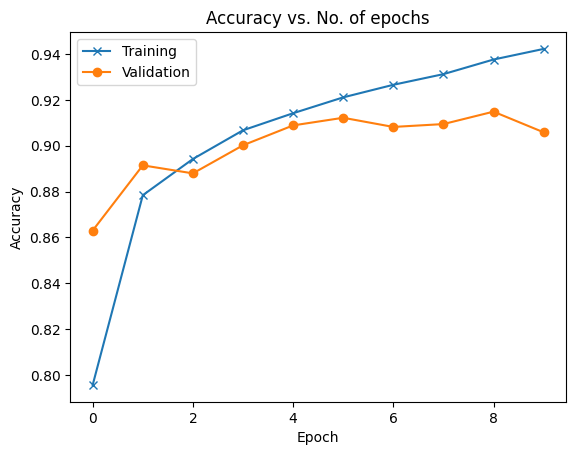

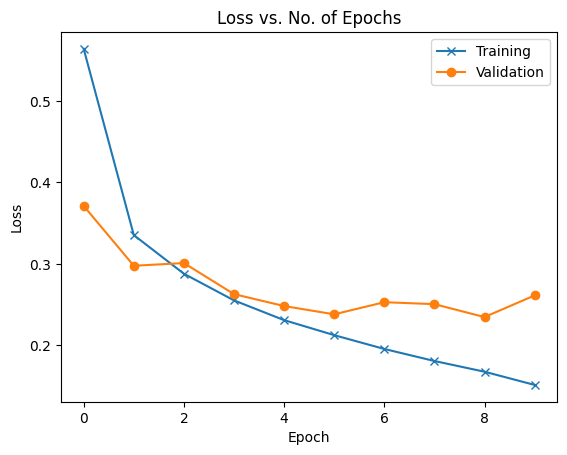

In [19]:
plot_accuracy(train_accuracies, val_accuracies)
plot_losses(train_losses, val_losses)

### Train a model on the entire dataset

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(n_epochs, model, train_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.

    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer function
        lr: learning rate

    Returns:
        model: the trained model
        train_loss_history: training loss history
        val_loss_history: validation loss history
        train_acc_history: training accuracy history
        val_acc_history: validation accuracy history
    """
    optimizer = opt_fn(model.parameters(), lr=lr)
    train_loss_history = []
    train_acc_history = []

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_dl:
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_dl)
        train_acc = correct / total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

    return model, train_loss_history, train_acc_history

In [26]:
indices, _ = split_indices(len(dataset), 0, rand_seed)

sampler = SubsetRandomSampler(indices)
dl = DataLoader(dataset, batch_size, sampler=sampler)

In [27]:
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, random_split

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training dataset
train_dataset = FashionMNIST('MNIST_data/', download=True, train=True, transform=transform)

# Split the dataset into training and validation sets
train_size = int(1 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Define data loaders
batch_size = 64
train_dl = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
model = ImageClassifierNet(n_channels=1)
loss_fn = nn.CrossEntropyLoss()
opt_fn = optim.Adam
lr = 0.001
num_epochs = 10


In [28]:
# Train the model
model, train_loss_history, train_acc_history = train_model(num_epochs, model, train_dl, loss_fn, opt_fn, lr)

Epoch 1/10, Train Loss: 0.5480, Train Acc: 0.7970
Epoch 2/10, Train Loss: 0.3297, Train Acc: 0.8798
Epoch 3/10, Train Loss: 0.2813, Train Acc: 0.8983
Epoch 4/10, Train Loss: 0.2493, Train Acc: 0.9085
Epoch 5/10, Train Loss: 0.2301, Train Acc: 0.9140
Epoch 6/10, Train Loss: 0.2095, Train Acc: 0.9222
Epoch 7/10, Train Loss: 0.1963, Train Acc: 0.9267
Epoch 8/10, Train Loss: 0.1819, Train Acc: 0.9331
Epoch 9/10, Train Loss: 0.1686, Train Acc: 0.9378
Epoch 10/10, Train Loss: 0.1557, Train Acc: 0.9428


### Check Predictions
Now, you should evaluate your model on dataset. Specifically, you should calculate the class probabilities for each image, and then visualize these probabilities along with the image itself. Please include a function `view_prediction` in your code that takes an image, its label, the calculated probabilities, and the list of class names as input, and plots the image along with the probabilities.

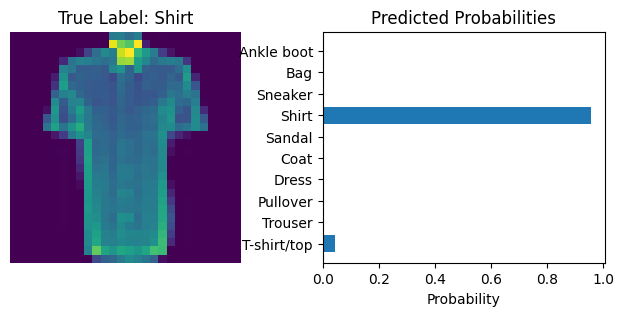

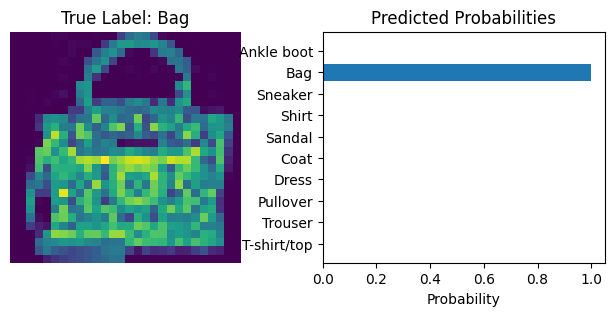

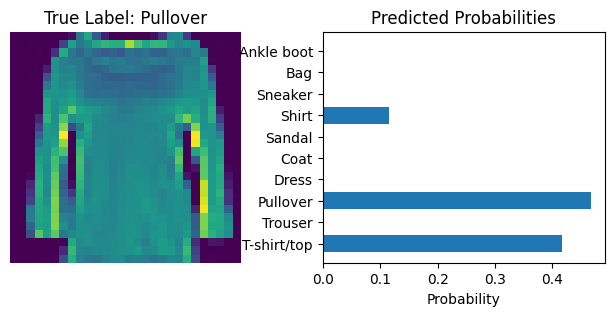

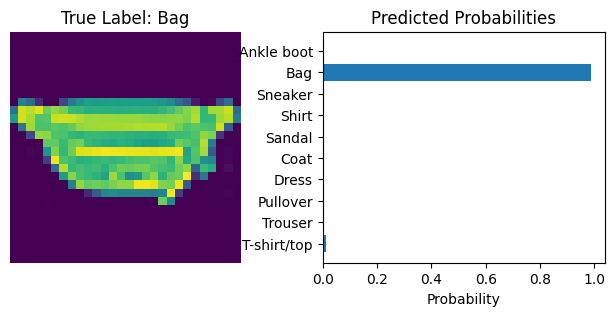

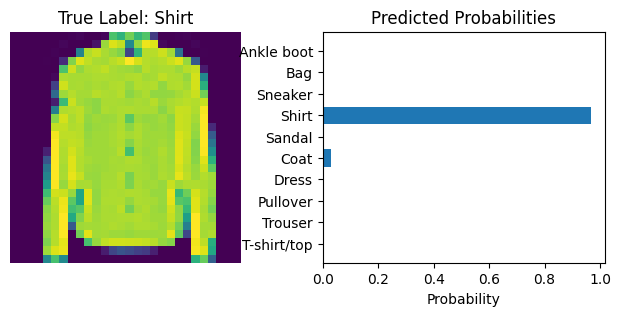

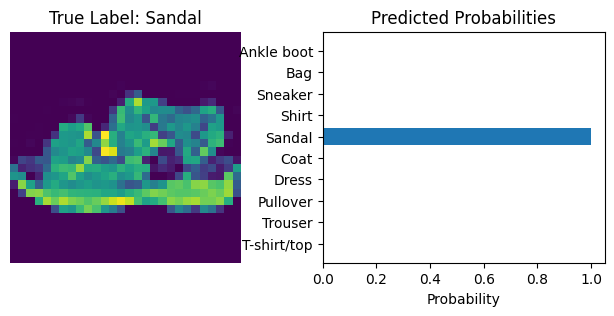

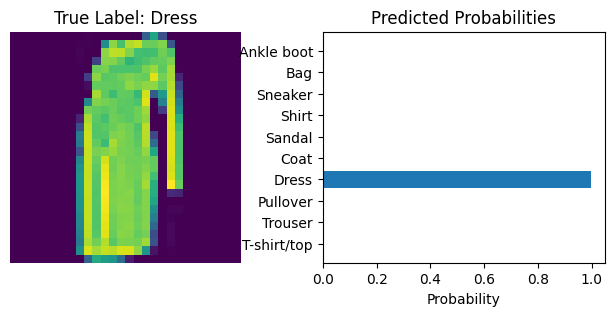

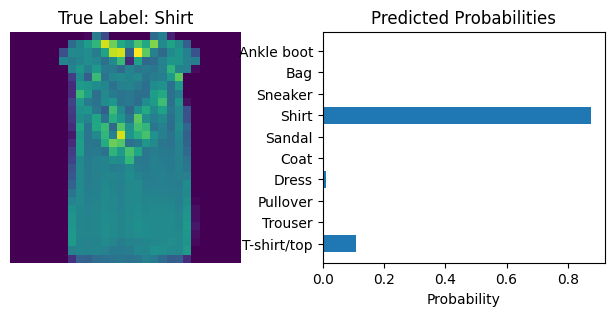

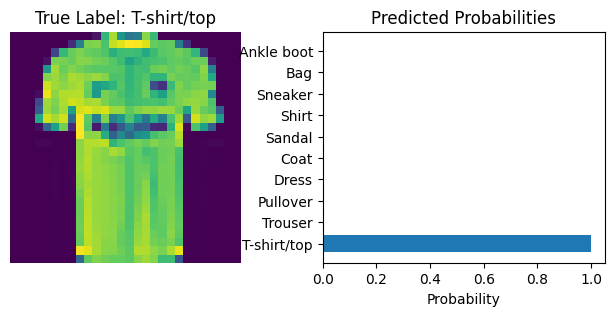

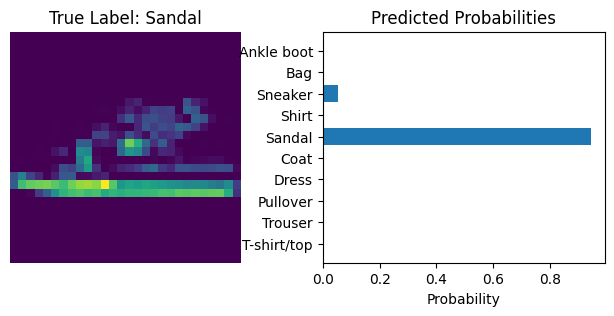

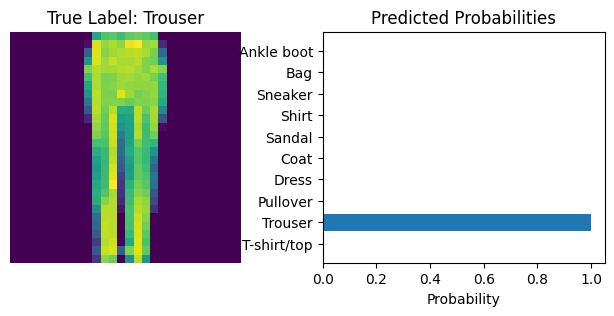

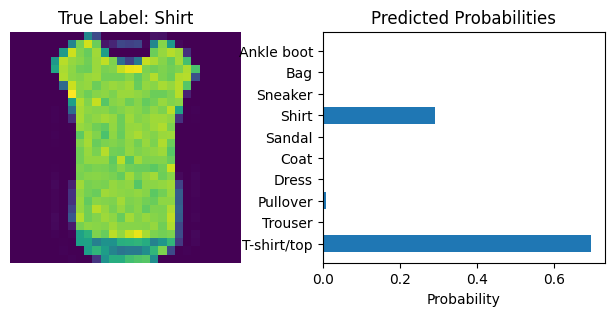

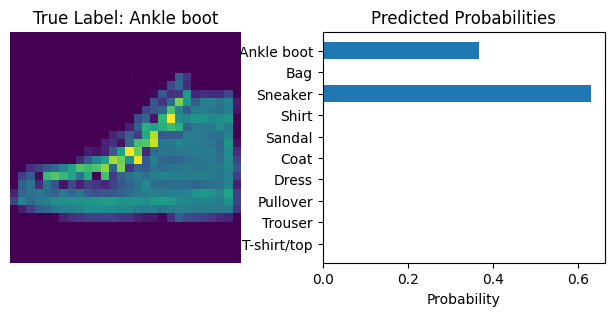

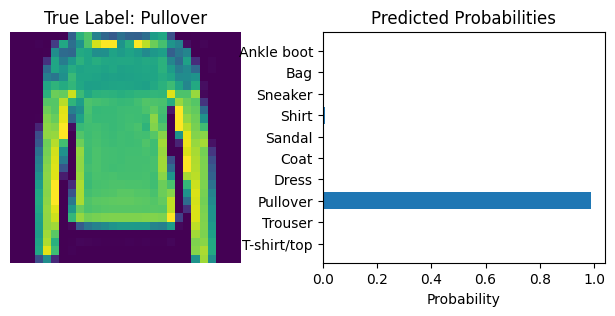

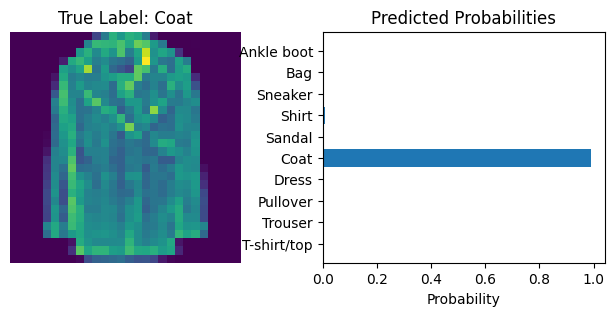

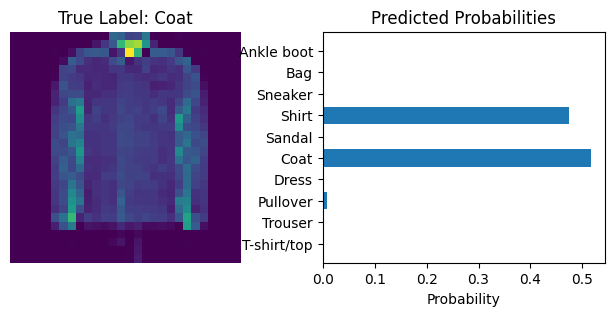

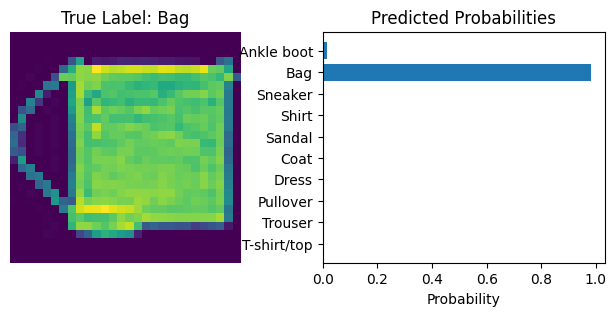

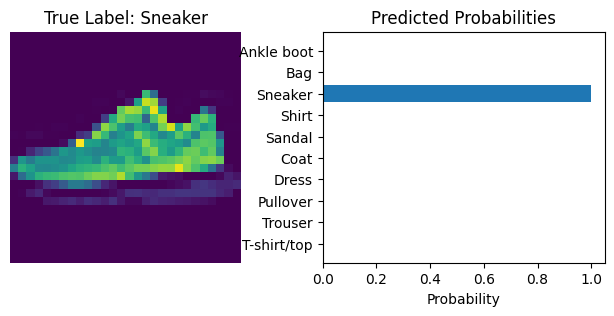

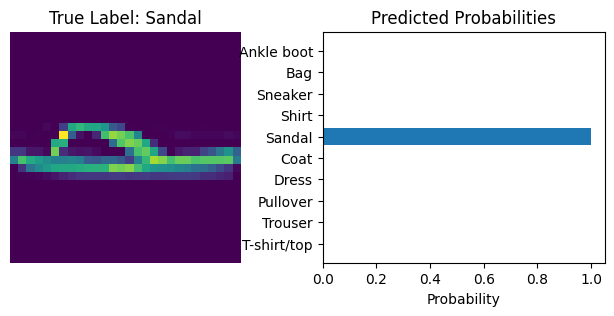

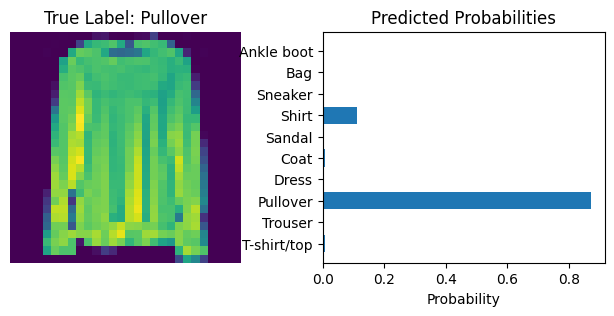

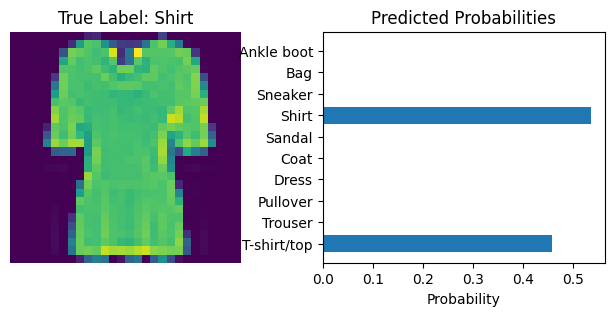

In [30]:
import matplotlib.pyplot as plt

def view_prediction(img, label, probs, class_names):
    """
    Displays the image along with the predicted probabilities.

    Args:
        img: the image tensor
        label: the true label of the image
        probs: the predicted probabilities for each class
        class_names: the list of class names
    """
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    ax1.imshow(np.transpose(np_img, (1, 2, 0)))
    ax1.axis('off')
    ax1.set_title(f'True Label: {class_names[label]}')

    y_pos = range(len(class_names))
    ax2.barh(y_pos, probs)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(class_names)
    ax2.set_xlabel('Probability')
    ax2.set_title('Predicted Probabilities')

    plt.show()

class_names = train_dataset.classes

def view(counter):
    # Get a batch of validation data
    images, labels = next(iter(train_dl))
    # Get the outputs for the first image in the batch
    output = model(images[counter].unsqueeze(0))
    # Calculate the probabilities
    probs = F.softmax(output, dim=1).detach().numpy().flatten()
    # View the prediction
    view_prediction(images[counter], labels[counter], probs, class_names)


# Loop to view predictions from counter 0 to 20
for counter in range(21):
    view(counter)


### Save the model

In [31]:
torch.save(model, 'model')

### Calculate accuracy on the test set

In [32]:
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

# Define the test dataset and data loader
test_dataset = FashionMNIST('MNIST_data/', download=True, train=False, transform=transform)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [33]:
def evaluate(model, test_dl):
    """
    Evaluates the model on the test data.

    Args:
        model: ImageClassifierNet object
        test_dl: test dataloader

    Returns:
        Test accuracy.
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_dl:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy



In [34]:
# Calculate and print the test accuracy
test_accuracy = evaluate(model, test_dl)
print(f"Test Accuracy = {test_accuracy:.4f}")

Test Accuracy = 0.9133
